In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom #pip install pydicom
import cv2 #pip install opencv-python
import tensorflow as tf
import shutil

In [2]:
#给定windowing自定义函数
def windowing(img, window_width, window_center):
    #img： 需要增强的图片
    #window_width:窗宽
    #window_center:中心
    minWindow = float(window_center)-0.5*float(window_width)
    new_img = (img-minWindow)/float(window_width)
    new_img[new_img<0] = 0
    new_img[new_img>1] = 1
    return (new_img*255).astype('uint8') #把数据整理成标准图像格式

In [3]:
def clahe_equalized(imgs):
    #输入imgs的形状必须是3维的 （129,512,512）
    assert(len(imgs.shape ) == 3)
    #定义均衡化函数
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize= (8,8))
    #新数组用来存放均衡化后的数据
    img_res = np.zeros_like(imgs)
    for i in range(len(imgs)):
        img_res[i,:,:] = clahe.apply(np.array(imgs[i,:,:],dtype=np.uint8))
    return img_res/255.0

In [4]:
#设置保存文件的路径
patient_save_path = r'Data/tmp/patient'
tumor_save_path = r'Data/tmp/tumor'
for path in [patient_save_path,tumor_save_path]:
    if os.path.exists(path): #判断文件夹是否存在
        shutil.rmtree(path)#如果存在就清空
    os.makedirs(path)#新增空文件夹用来存放数据

In [5]:
for num in range(1,21):
    print('正在处理第%d位病人的数据'%num)
    #======CT图处理===================
    #读取CT图数据
    data_path = fr'Data\3Dircadb1.{num}\PATIENT_DICOM'
    #批量数据读取
    image_slices = [pydicom.dcmread(os.path.join(data_path,file_name)) for file_name in os.listdir(data_path)]
    os.listdir(data_path)#默认按照字符排序，顺序乱掉了
    #重新排序,避免CT图乱序
    image_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
    #提取像素值
    image_array = np.array([i.pixel_array for i in image_slices])
    #CT图增强-windowing
    img_ct = windowing(image_array,250,0)
    #直方图均衡化
    img_clahe = clahe_equalized(img_ct)
    #=======掩模图处理==================================
    #保存所有的肿瘤数据
    livertumor_path = fr'Data\3Dircadb1.{num}\MASKS_DICOM'
    #肿瘤路径
    tumor_paths = [os.path.join(livertumor_path,i) for i in os.listdir(livertumor_path) if 'livertumor' in i]
    tumor_paths.sort()
    #提取所有肿瘤数据
    j = 0
    for tumor_path in tumor_paths:
        print('正在处理第%d个肿瘤'%j)
        #批量数据读取
        tumor_slices = [pydicom.dcmread(os.path.join(tumor_path,file_name)) for file_name in os.listdir(tumor_path)]
        #重新排序,避免CT图乱序
        tumor_slices.sort(key=lambda x:x.InstanceNumber)#顺序属性
        #提取像素值
        tumor_array = np.array([i.pixel_array for i in tumor_slices])
        #没有肿瘤的掩模图全部是黑色,对应的像素数组全为0
        index = [i.sum()>0  for i in tumor_array] #提取含肿瘤部分
        #提取掩模图的肿瘤部分
        img_tumor = tumor_array[index]
        #对增强后的CT图提取肿瘤部分
        img_patient = img_clahe[index]
        #保存数据
        for i in range(len(img_patient)):
            plt.imsave(os.path.join(patient_save_path,f'{num}_{j}_{i}.jpg'),img_patient[i],cmap = 'gray')#CT图
            plt.imsave(os.path.join(tumor_save_path,f'{num}_{j}_{i}.jpg'),img_tumor[i],cmap = 'gray')#掩模图
        j += 1

正在处理第1位病人的数据
正在处理第0个肿瘤
正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第3个肿瘤
正在处理第4个肿瘤
正在处理第5个肿瘤
正在处理第6个肿瘤
正在处理第2位病人的数据
正在处理第0个肿瘤
正在处理第3位病人的数据
正在处理第0个肿瘤
正在处理第4位病人的数据
正在处理第0个肿瘤
正在处理第5位病人的数据
正在处理第6位病人的数据
正在处理第0个肿瘤
正在处理第7位病人的数据
正在处理第8位病人的数据
正在处理第0个肿瘤
正在处理第1个肿瘤
正在处理第2个肿瘤
正在处理第9位病人的数据
正在处理第0个肿瘤
正在处理第10位病人的数据
正在处理第0个肿瘤
正在处理第11位病人的数据
正在处理第12位病人的数据
正在处理第0个肿瘤
正在处理第13位病人的数据
正在处理第0个肿瘤
正在处理第14位病人的数据
正在处理第15位病人的数据
正在处理第0个肿瘤
正在处理第16位病人的数据
正在处理第0个肿瘤
正在处理第17位病人的数据
正在处理第0个肿瘤
正在处理第1个肿瘤
正在处理第18位病人的数据
正在处理第19位病人的数据
正在处理第0个肿瘤
正在处理第20位病人的数据


In [1]:
import os
import shutil
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import  backend as K
from tensorflow.keras.layers import  *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#保存图形增强后数据的路径
# save_datagen_path_ct = r'Data\tmp2\ct'
# save_datagen_path_mask=r'Data\tmp2\mask'
save_datagen_path=r'Data\tmp2'
# if os.path.exists(save_datagen_path_ct or save_datagen_path_mask ):
#     shutil.rmtree(save_datagen_path_ct)
#     shutil.rmtree(save_datagen_path_mask)
if os.path.exists(save_datagen_path ):
    shutil.rmtree(save_datagen_path)
#     shutil.rmtree(save_datagen_path_mask)
# os.makedirs(save_datagen_path_mask)
# os.makedirs(save_datagen_path_ct)
os.makedirs(save_datagen_path)


In [3]:
def adjust_data(ct,mask):
    #ct： CT图
    #mask：掩模图
    ct = ct/255.0
    mask = mask/255.0
    mask[mask>0.5] = 1#对掩模图做灰度处理
    mask[mask<=0.5] = 0
    return ct,mask

In [4]:
#自定义图像增强函数
def train_generator():
    #======1、定义图像生成器============================
    generator_args = dict(
        rotation_range = 0.1,#旋转角度
        width_shift_range = 0.05,#水平移动
        height_shift_range = 0.05,#垂直移动
        shear_range = 0.05,#剪切
        zoom_range = 0.05,#缩放
        horizontal_flip = False,#水平翻转
        vertical_flip = False,#垂直翻转
    )
    #=====2、分别对CT图和掩模图做图像增强===================================
    ct_datagen = ImageDataGenerator(generator_args)#CT图片生成器
    mask_datagen = ImageDataGenerator(generator_args)#掩模图片生成器
    
    #====3、实现图像增强=====================================================
    generator_path = r'Data\tmp'
    ct_generator = ct_datagen.flow_from_directory(
        generator_path,#目标路径
        classes = ['patient'],#处理的文件夹
        class_mode = None,
        color_mode = 'grayscale',#灰度图
        target_size = (512,512),#图片大小
        batch_size = 2,#图片个数
        save_to_dir = save_datagen_path,#保存
        save_prefix = 'ct_' ,#增强后图片的前缀
        seed = 123,
    )
    mask_generator = mask_datagen.flow_from_directory(
        generator_path,#目标路径
        classes = ['tumor'],#处理的文件夹
        class_mode = None,
        color_mode = 'grayscale',#灰度图
        target_size = (512,512),#图片大小
        batch_size = 2,#图片个数
        save_to_dir = save_datagen_path,#保存
        save_prefix = 'mask_' ,#增强后图片的前缀
        seed = 123,
    )
    train_generator = zip(ct_generator,mask_generator)#成组处理
    #============4、增强后的图片做归一化处理==========================
    for (ct,mask) in train_generator:
        yield adjust_data(ct,mask)

Found 632 images belonging to 1 classes.
Found 632 images belonging to 1 classes.
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 512, 1)
(512, 512) (2, 512, 51

KeyboardInterrupt: 

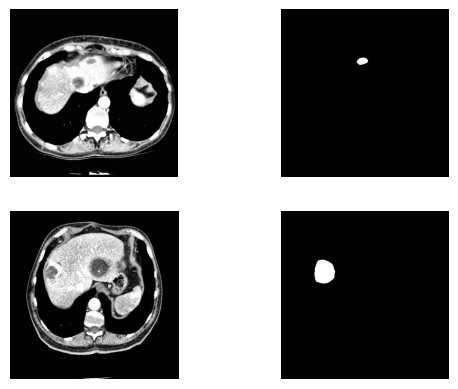

In [6]:
gene = train_generator() #模型的输入和输出，可以直接放在模型的训练里面
#可视化
for ct,mask in gene:
    print(ct[0][:,:,0].shape,mask.shape)
    plt.subplot(2,2,1)
    plt.imshow(ct[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(mask[0][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(ct[1][:,:,0],cmap='gray')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(mask[1][:,:,0],cmap='gray')
    plt.axis('off')
#     break
plt.show()

In [30]:
K.clear_session()
model_path = r'Data\model.keras'

def u_net(input_size=(512,512,1),path = model_path):
    inputs = Input(input_size)
    conv1 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(inputs)
    conv2 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPool2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    conv4 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv3)
    pool2 = MaxPool2D(pool_size=(2,2))(conv4)
    
    conv5 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    conv6 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv5)
    pool3 = MaxPool2D(pool_size=(2,2))(conv6)
    
    conv7 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    conv8 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv7)
    pool4 = MaxPool2D(pool_size=(2,2))(conv8)
    
    conv9 = Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    conv10 = Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv9)
    up1 = UpSampling2D((2,2))(conv10)#反卷积
    
    conv11 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up1,conv8],axis=3))#开始右半部分
    conv12 = Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv11)
    up2 = UpSampling2D((2,2))(conv12)#反卷积
    
    conv13 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up2,conv6],axis=3))
    conv14 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv13)
    up3 = UpSampling2D((2,2))(conv14)#反卷积
    
    conv15 = Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up3,conv4],axis=3))
    conv16 = Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv15)
    up4 = UpSampling2D((2,2))(conv16)#反卷积
    
    conv17 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(
        concatenate([up4,conv2],axis=3))
    conv18 = Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv17)
    out = Conv2D(1,1,activation='sigmoid')(conv18)
    
    model = tf.keras.Model(inputs = inputs,outputs = out)#构建模型
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])#模型编译
    #model.summary()
    return model

In [34]:
model = u_net()
model.summary()
model.load_weights("model_days.keras")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 512, 512, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_38 (Conv2D)            │ (None, 512, 512, 64)      │             640 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_39 (Conv2D)            │ (None, 512, 512, 64)      │          36,928 │ conv2d_38[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 256, 256, 64)      │               0 │ conv2d_39[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_40 (Conv2D)            │ (None, 256, 256, 128)     │          73,856 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_41 (Conv2D)            │ (None, 256, 256, 128)     │         147,584 │ conv2d_40[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_9               │ (None, 128, 128, 128)     │               0 │ conv2d_41[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_42 (Conv2D)            │ (None, 128, 128, 256)     │         295,168 │ max_pooling2d_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_43 (Conv2D)            │ (None, 128, 128, 256)     │         590,080 │ conv2d_42[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_10              │ (None, 64, 64, 256)       │               0 │ conv2d_43[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_44 (Conv2D)            │ (None, 64, 64, 512)       │       1,180,160 │ max_pooling2d_10[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_45 (Conv2D)            │ (None, 64, 64, 512)       │       2,359,808 │ conv2d_44[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_11              │ (None, 32, 32, 512)       │               0 │ conv2d_45[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_46 (Conv2D)            │ (None, 32, 32, 1024)      │       4,719,616 │ max_pooling2d_11[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_47 (Conv2D)            │ (None, 32, 32, 1024)      │       9,438,208 │ conv2d_46[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 31,599,105 (120.54 MB)

 Trainable params: 31,599,105 (120.54 MB)

 Non-trainable params: 0 (0.00 B)

D:\Anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9914 - loss: 0.0433 
Epoch 1: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


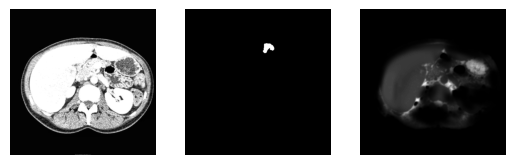

100/100 ━━━━━━━━━━━━━━━━━━━━ 1934s 19s/step - accuracy: 0.9914 - loss: 0.0433
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9912 - loss: 0.0333 
Epoch 2: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


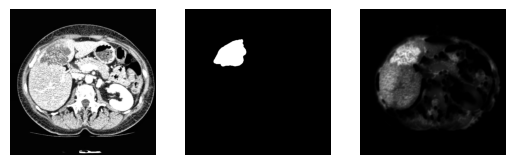

100/100 ━━━━━━━━━━━━━━━━━━━━ 2037s 20s/step - accuracy: 0.9912 - loss: 0.0333
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9906 - loss: 0.0334 
Epoch 3: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


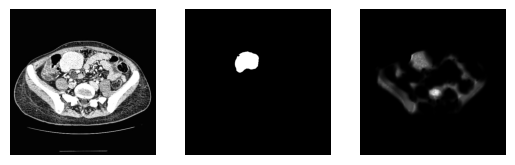

100/100 ━━━━━━━━━━━━━━━━━━━━ 2089s 21s/step - accuracy: 0.9906 - loss: 0.0334
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9900 - loss: 0.0379 
Epoch 4: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


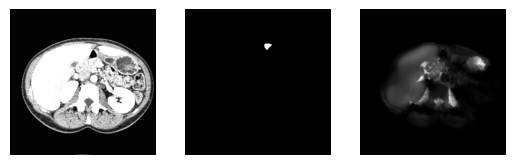

100/100 ━━━━━━━━━━━━━━━━━━━━ 2044s 20s/step - accuracy: 0.9900 - loss: 0.0379
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9920 - loss: 0.0342 
Epoch 5: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


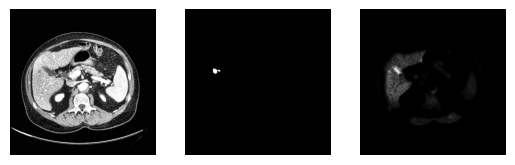

100/100 ━━━━━━━━━━━━━━━━━━━━ 2052s 21s/step - accuracy: 0.9920 - loss: 0.0342
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9902 - loss: 0.0331 
Epoch 6: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


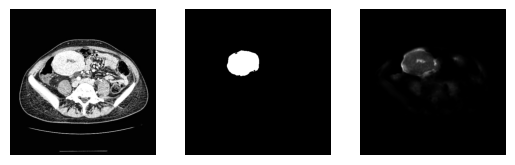

100/100 ━━━━━━━━━━━━━━━━━━━━ 1996s 20s/step - accuracy: 0.9902 - loss: 0.0331
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9921 - loss: 0.0292 
Epoch 7: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


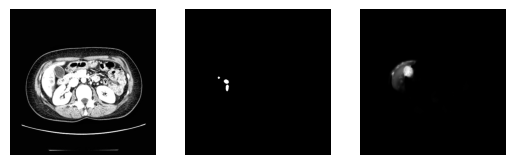

100/100 ━━━━━━━━━━━━━━━━━━━━ 1927s 19s/step - accuracy: 0.9921 - loss: 0.0292
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9909 - loss: 0.0325 
Epoch 8: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


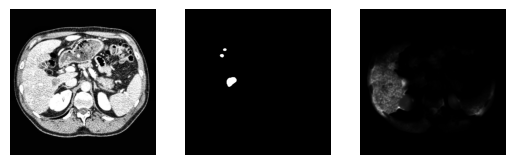

100/100 ━━━━━━━━━━━━━━━━━━━━ 1996s 20s/step - accuracy: 0.9909 - loss: 0.0325
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9904 - loss: 0.0271 
Epoch 9: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


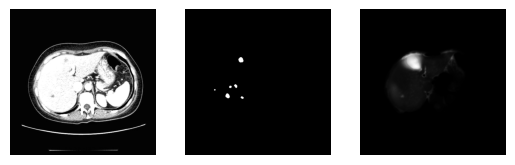

100/100 ━━━━━━━━━━━━━━━━━━━━ 1954s 20s/step - accuracy: 0.9904 - loss: 0.0271
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9908 - loss: 0.0335 
Epoch 10: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


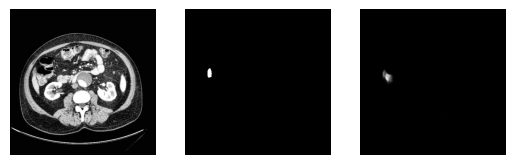

100/100 ━━━━━━━━━━━━━━━━━━━━ 2052s 21s/step - accuracy: 0.9908 - loss: 0.0335
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9913 - loss: 0.0270 
Epoch 11: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


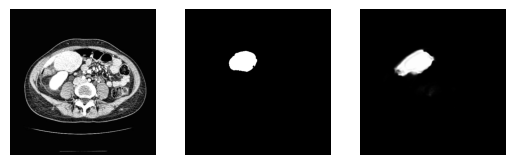

100/100 ━━━━━━━━━━━━━━━━━━━━ 2197s 22s/step - accuracy: 0.9913 - loss: 0.0270
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.9894 - loss: 0.0233 
Epoch 12: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


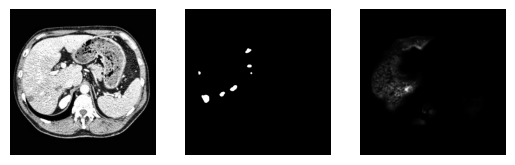

100/100 ━━━━━━━━━━━━━━━━━━━━ 2483s 25s/step - accuracy: 0.9894 - loss: 0.0233
Epoch 13/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.9910 - loss: 0.0229 
Epoch 13: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


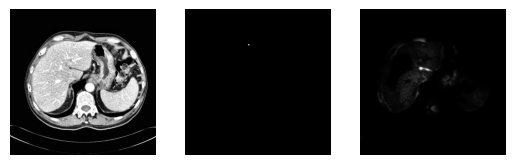

100/100 ━━━━━━━━━━━━━━━━━━━━ 2485s 25s/step - accuracy: 0.9910 - loss: 0.0228
Epoch 14/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.9928 - loss: 0.0205 
Epoch 14: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


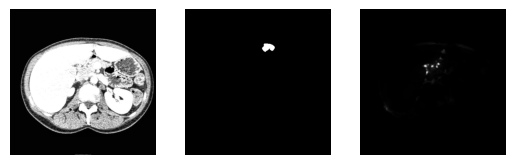

100/100 ━━━━━━━━━━━━━━━━━━━━ 2486s 25s/step - accuracy: 0.9928 - loss: 0.0205
Epoch 15/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9937 - loss: 0.0183 
Epoch 15: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


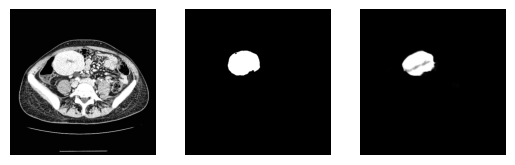

100/100 ━━━━━━━━━━━━━━━━━━━━ 1994s 20s/step - accuracy: 0.9937 - loss: 0.0183
Epoch 16/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9931 - loss: 0.0194 
Epoch 16: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


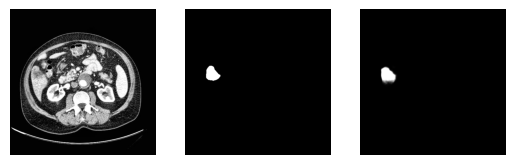

100/100 ━━━━━━━━━━━━━━━━━━━━ 1935s 19s/step - accuracy: 0.9931 - loss: 0.0194
Epoch 17/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9947 - loss: 0.0153 
Epoch 17: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


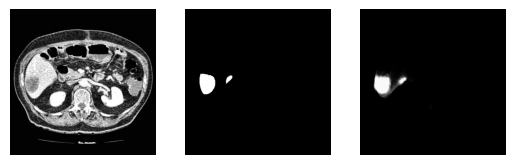

100/100 ━━━━━━━━━━━━━━━━━━━━ 1932s 19s/step - accuracy: 0.9947 - loss: 0.0153
Epoch 18/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9956 - loss: 0.0134 
Epoch 18: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


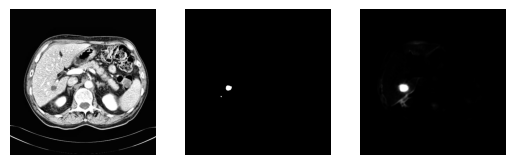

100/100 ━━━━━━━━━━━━━━━━━━━━ 1931s 19s/step - accuracy: 0.9956 - loss: 0.0134
Epoch 19/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9953 - loss: 0.0133 
Epoch 19: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


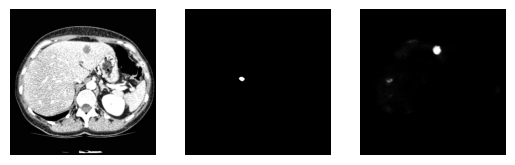

100/100 ━━━━━━━━━━━━━━━━━━━━ 1934s 19s/step - accuracy: 0.9953 - loss: 0.0133
Epoch 20/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9955 - loss: 0.0125 
Epoch 20: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


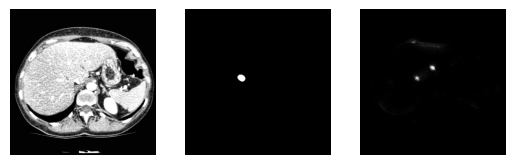

100/100 ━━━━━━━━━━━━━━━━━━━━ 1936s 19s/step - accuracy: 0.9955 - loss: 0.0125
Epoch 21/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9945 - loss: 0.0147 
Epoch 21: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


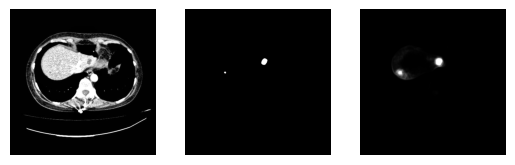

100/100 ━━━━━━━━━━━━━━━━━━━━ 1934s 19s/step - accuracy: 0.9945 - loss: 0.0147
Epoch 22/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9956 - loss: 0.0128 
Epoch 22: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


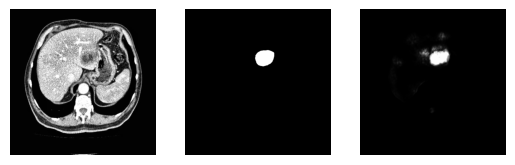

100/100 ━━━━━━━━━━━━━━━━━━━━ 1950s 19s/step - accuracy: 0.9956 - loss: 0.0127
Epoch 23/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9949 - loss: 0.0136 
Epoch 23: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


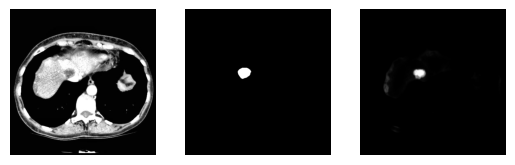

100/100 ━━━━━━━━━━━━━━━━━━━━ 1943s 19s/step - accuracy: 0.9949 - loss: 0.0136
Epoch 24/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9960 - loss: 0.0111 
Epoch 24: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


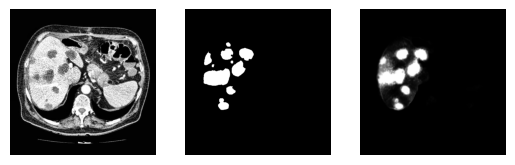

100/100 ━━━━━━━━━━━━━━━━━━━━ 1950s 19s/step - accuracy: 0.9960 - loss: 0.0111
Epoch 25/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9963 - loss: 0.0105 
Epoch 25: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


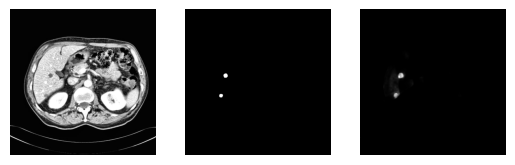

100/100 ━━━━━━━━━━━━━━━━━━━━ 1946s 19s/step - accuracy: 0.9963 - loss: 0.0105
Epoch 26/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9957 - loss: 0.0114 
Epoch 26: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


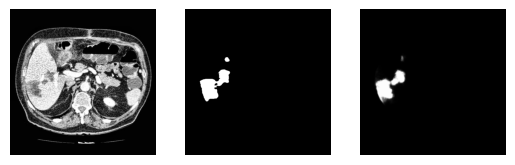

100/100 ━━━━━━━━━━━━━━━━━━━━ 1947s 19s/step - accuracy: 0.9957 - loss: 0.0114
Epoch 27/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9906 - loss: 0.0500 
Epoch 27: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


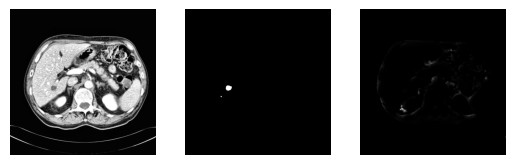

100/100 ━━━━━━━━━━━━━━━━━━━━ 1927s 19s/step - accuracy: 0.9906 - loss: 0.0507
Epoch 28/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9798 - loss: 0.3472 
Epoch 28: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


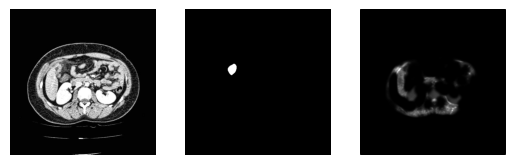

100/100 ━━━━━━━━━━━━━━━━━━━━ 1925s 19s/step - accuracy: 0.9798 - loss: 0.3460
Epoch 29/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9910 - loss: 0.0354 
Epoch 29: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


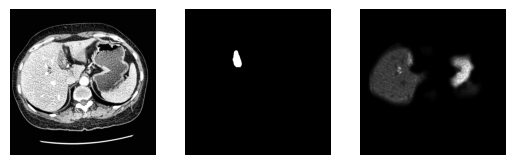

100/100 ━━━━━━━━━━━━━━━━━━━━ 1929s 19s/step - accuracy: 0.9910 - loss: 0.0354
Epoch 30/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9913 - loss: 0.0348 
Epoch 30: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


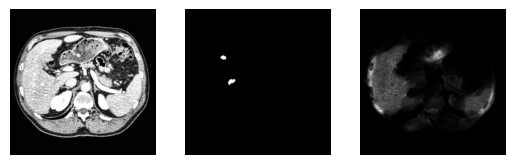

100/100 ━━━━━━━━━━━━━━━━━━━━ 1931s 19s/step - accuracy: 0.9913 - loss: 0.0348
Epoch 31/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9904 - loss: 0.0338 
Epoch 31: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


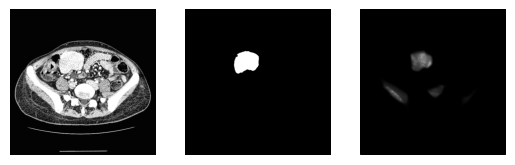

100/100 ━━━━━━━━━━━━━━━━━━━━ 1927s 19s/step - accuracy: 0.9904 - loss: 0.0338
Epoch 32/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9917 - loss: 0.0322 
Epoch 32: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


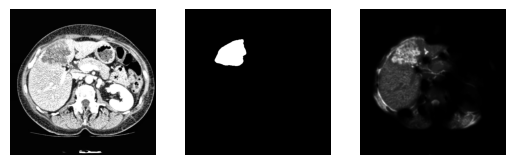

100/100 ━━━━━━━━━━━━━━━━━━━━ 1929s 19s/step - accuracy: 0.9917 - loss: 0.0322
Epoch 33/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9921 - loss: 0.0302 
Epoch 33: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


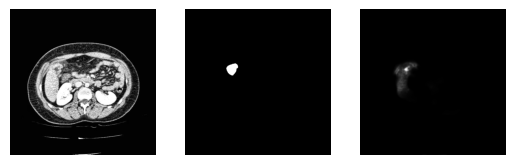

100/100 ━━━━━━━━━━━━━━━━━━━━ 1927s 19s/step - accuracy: 0.9921 - loss: 0.0301
Epoch 34/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9893 - loss: 0.0329 
Epoch 34: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


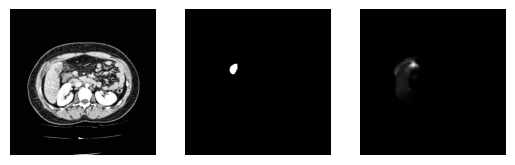

100/100 ━━━━━━━━━━━━━━━━━━━━ 1988s 20s/step - accuracy: 0.9893 - loss: 0.0329
Epoch 35/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9904 - loss: 0.0309 
Epoch 35: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


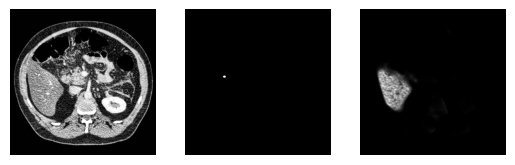

100/100 ━━━━━━━━━━━━━━━━━━━━ 2062s 21s/step - accuracy: 0.9904 - loss: 0.0310
Epoch 36/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9908 - loss: 0.0290 
Epoch 36: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


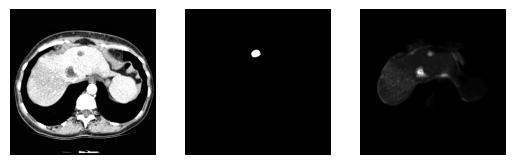

100/100 ━━━━━━━━━━━━━━━━━━━━ 2239s 22s/step - accuracy: 0.9908 - loss: 0.0290
Epoch 37/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9919 - loss: 0.0270 
Epoch 37: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


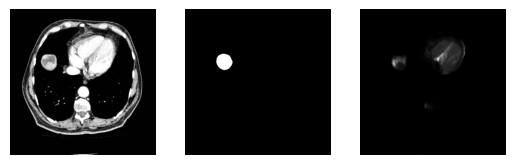

100/100 ━━━━━━━━━━━━━━━━━━━━ 2032s 20s/step - accuracy: 0.9919 - loss: 0.0270
Epoch 38/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9898 - loss: 0.0302 
Epoch 38: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


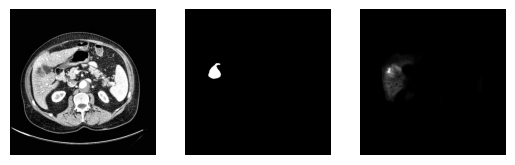

100/100 ━━━━━━━━━━━━━━━━━━━━ 1884s 19s/step - accuracy: 0.9899 - loss: 0.0302
Epoch 39/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9923 - loss: 0.0239 
Epoch 39: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


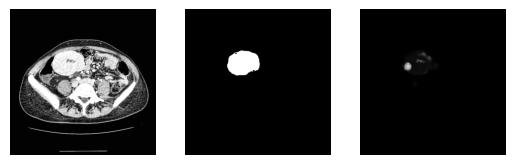

100/100 ━━━━━━━━━━━━━━━━━━━━ 1910s 19s/step - accuracy: 0.9922 - loss: 0.0240
Epoch 40/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9935 - loss: 0.0222 
Epoch 40: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


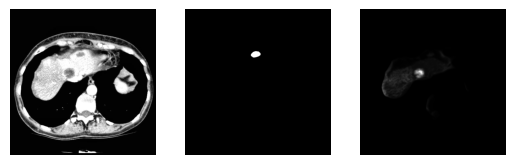

100/100 ━━━━━━━━━━━━━━━━━━━━ 1958s 20s/step - accuracy: 0.9935 - loss: 0.0222
Epoch 41/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9932 - loss: 0.0220 
Epoch 41: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


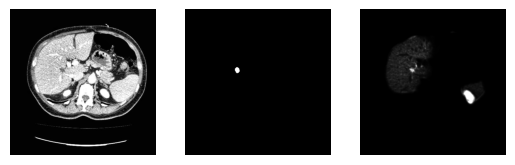

100/100 ━━━━━━━━━━━━━━━━━━━━ 1991s 20s/step - accuracy: 0.9932 - loss: 0.0220
Epoch 42/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9917 - loss: 0.0240 
Epoch 42: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


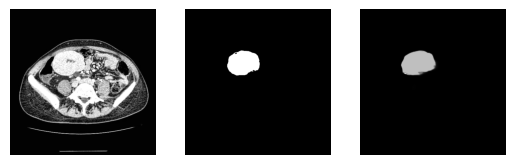

100/100 ━━━━━━━━━━━━━━━━━━━━ 1899s 19s/step - accuracy: 0.9917 - loss: 0.0239
Epoch 43/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9933 - loss: 0.0219 
Epoch 43: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


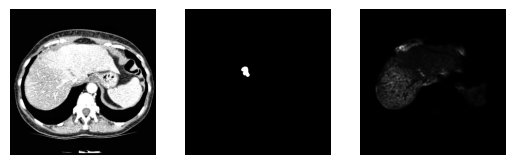

100/100 ━━━━━━━━━━━━━━━━━━━━ 2270s 23s/step - accuracy: 0.9933 - loss: 0.0219
Epoch 44/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9937 - loss: 0.0195 
Epoch 44: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


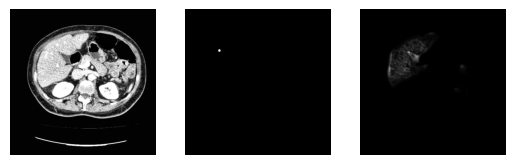

100/100 ━━━━━━━━━━━━━━━━━━━━ 2448s 24s/step - accuracy: 0.9937 - loss: 0.0195
Epoch 45/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.9930 - loss: 0.0213 
Epoch 45: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


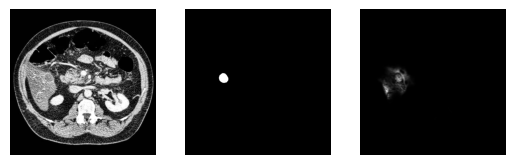

100/100 ━━━━━━━━━━━━━━━━━━━━ 3967s 40s/step - accuracy: 0.9930 - loss: 0.0213
Epoch 46/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 107s/step - accuracy: 0.9945 - loss: 0.0173  
Epoch 46: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


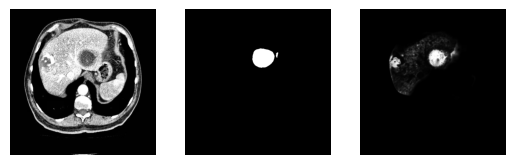

100/100 ━━━━━━━━━━━━━━━━━━━━ 10632s 107s/step - accuracy: 0.9945 - loss: 0.0173
Epoch 47/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9943 - loss: 0.0191 
Epoch 47: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


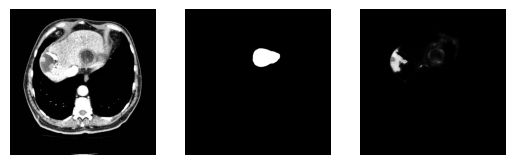

100/100 ━━━━━━━━━━━━━━━━━━━━ 1861s 19s/step - accuracy: 0.9943 - loss: 0.0192
Epoch 48/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9938 - loss: 0.0211 
Epoch 48: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


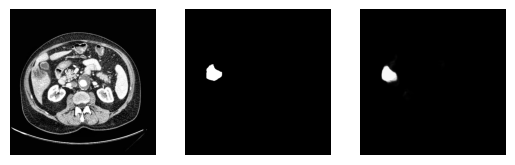

100/100 ━━━━━━━━━━━━━━━━━━━━ 1894s 19s/step - accuracy: 0.9938 - loss: 0.0210
Epoch 49/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9932 - loss: 0.0203 
Epoch 49: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


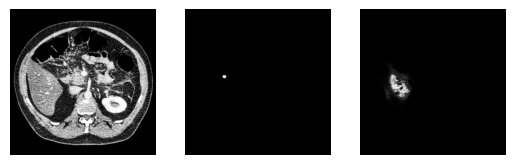

100/100 ━━━━━━━━━━━━━━━━━━━━ 1901s 19s/step - accuracy: 0.9932 - loss: 0.0203
Epoch 50/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9936 - loss: 0.0199 
Epoch 50: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


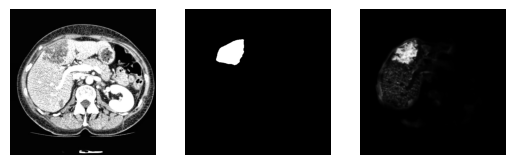

100/100 ━━━━━━━━━━━━━━━━━━━━ 1917s 19s/step - accuracy: 0.9936 - loss: 0.0199
Epoch 51/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9945 - loss: 0.0171 
Epoch 51: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


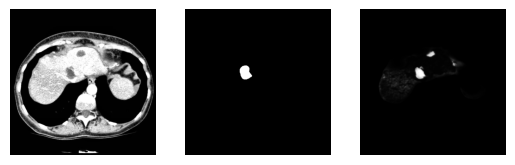

100/100 ━━━━━━━━━━━━━━━━━━━━ 1895s 19s/step - accuracy: 0.9945 - loss: 0.0171
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9935 - loss: 0.0196 
Epoch 52: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


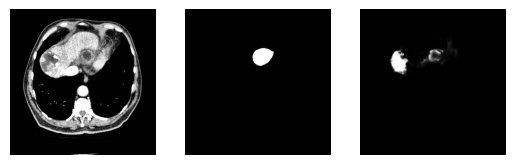

100/100 ━━━━━━━━━━━━━━━━━━━━ 1889s 19s/step - accuracy: 0.9935 - loss: 0.0196
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9945 - loss: 0.0184 
Epoch 53: saving model to Data\model.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


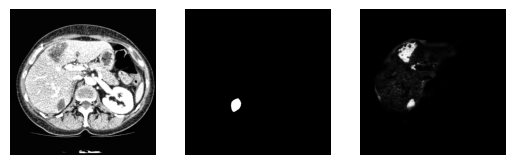

100/100 ━━━━━━━━━━━━━━━━━━━━ 1989s 20s/step - accuracy: 0.9945 - loss: 0.0184
Epoch 54/100
 94/100 ━━━━━━━━━━━━━━━━━━━━ 21:49 218s/step - accuracy: 0.9946 - loss: 0.0166

In [ ]:
model_ckpt = ModelCheckpoint(model_path,save_best_only=False,verbose=1)
class ShowMask(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        print()
        for ct, mask in gene:
            plt.subplot(1, 3, 1)
            plt.imshow(ct[0], cmap='gray')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0], cmap='gray')
            plt.axis('off')  
            plt.subplot(1, 3, 3)
            plt.imshow(model.predict(ct[0].reshape(1, 512, 512, 1))[0], cmap='gray')
            plt.axis('off')
            plt.show()
            break

model.fit(gene,steps_per_epoch=100,epochs=100,callbacks=[model_ckpt,ShowMask()])

1_4_8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
206


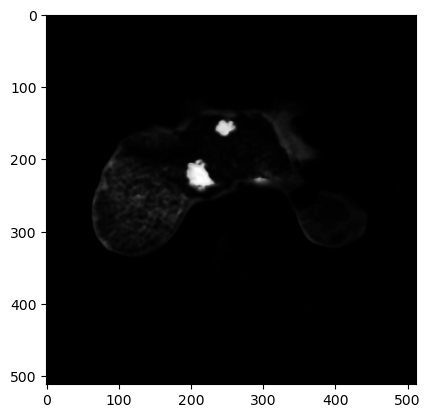

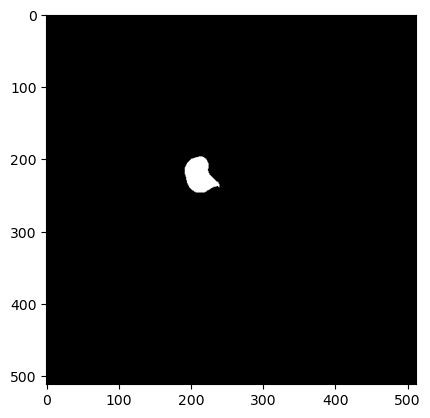

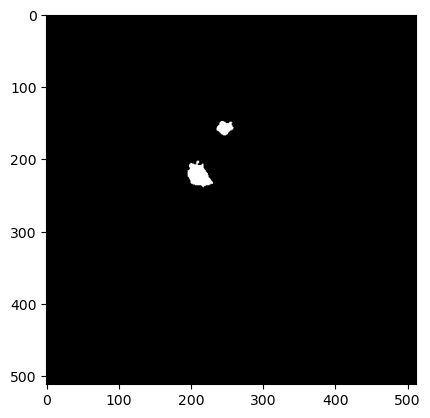

10_0_39
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
205


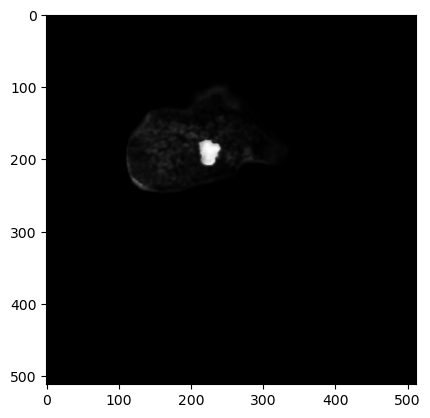

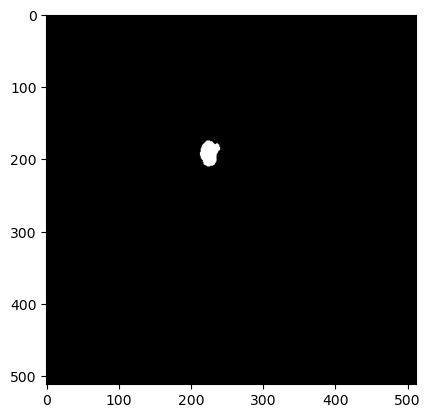

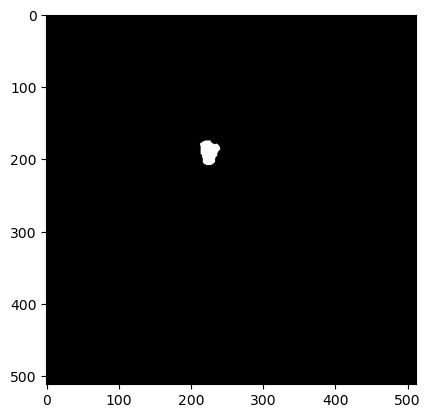

13_0_45
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
206


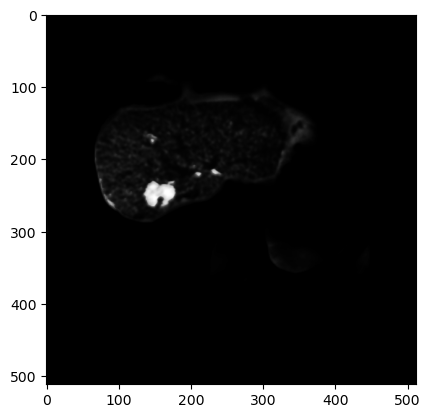

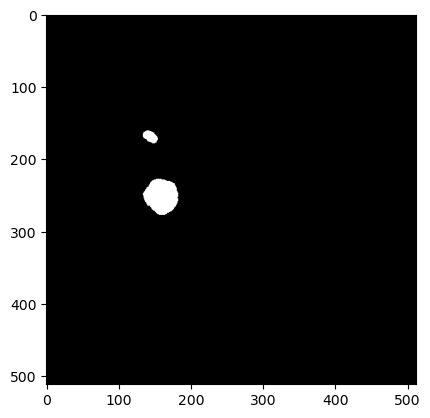

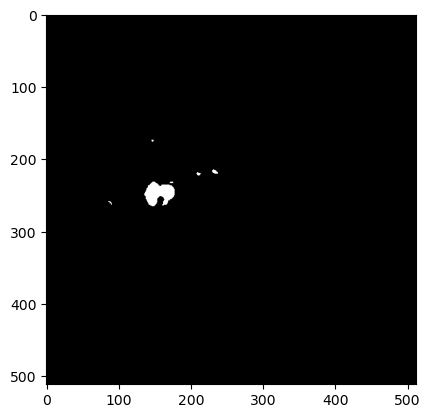

In [6]:
# patient_id = '1_1_1'
list1=['1_4_8','10_0_39','13_0_45']
for i in list1:
    print(i)
    # 1.1读取病人的CT图（tmp文件夹，已经做了windowing、直方图均衡化）
    patient_ct = cv2.imread(f'Data/tmp/patient/{i}.jpg')
    # 1.2读取病人掩膜图
    patient_mask = cv2.imread(f'Data/tmp/tumor/{i}.jpg', cv2.IMREAD_GRAYSCALE)


    # 2.1模型加载（已经训练好的模型）
    model_test = tf.keras.models.load_model('Data\model.keras')
    # 2.2 模型输入的处理
    # 2.2.1 灰度处理
    ct_gray = cv2.cvtColor(patient_ct, cv2.COLOR_BGR2GRAY)
    # 2.2.2 数据形状（batch_size, img_height, img_height, img_channel_size）
    ct_gray = ct_gray.reshape((1, 512, 512, 1))
    # 2.2.3 归一化
    ct_gray = ct_gray/ 255.
    # 2.3 模型预测
    predict = model_test.predict(ct_gray)
    pred_mask=predict[0]
    plt.imshow((pred_mask*255).astype('uint8'),cmap='gray')
    cv2.imwrite(f'patient{i}.jpg',(pred_mask*255).astype('uint8'))
    print(np.max((pred_mask*255).astype('uint8')))
    plt.show()
    # 3结果展示
    _, patient_mask = cv2.threshold(patient_mask, 127, 255, 0)
    plt.imshow(patient_mask,cmap='gray')
    plt.show()
    # 3.1轮廓线提取
    contours, _ = cv2.findContours(patient_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # 3.2在CT图上绘制轮廓线
    overlap_img = cv2.drawContours(patient_ct.copy(), contours, -1, (0, 255, 0), 2)
    # 3.3 展示
    cv2.imshow('real', overlap_img)
    cv2.waitKey(0)


    # # 3结果展示
    _, bi_mask = cv2.threshold((pred_mask*255).astype('uint8'), 127, 255, 0)
    plt.imshow(bi_mask,cmap='gray')
    plt.show()
#     cv2.imshow('predict',bi_mask)
    # 3.1轮廓线提取
    contours, _ = cv2.findContours(bi_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # 3.2在CT图上绘制轮廓线
    overlap_img2 = cv2.drawContours(patient_ct.copy(), contours, -1, (255, 0, 0), 2)
    # 3.3 展示
    cv2.imshow('predict', overlap_img2)
    cv2.waitKey(0)